<h1>Data Modeling</h1>

The first thing we need to do is import all the necessary packages and the train/test data previously scaled and ready to model.

In [1]:
# start by import necessary packages
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
import random 
random.seed(123)

In [3]:
#load the train/test sets saved
X_train = np.load('../data/train_test/xtrainV2.npy')
X_test = np.load('../data/train_test/xtestV2.npy')
y_train = np.load('../data/train_test/ytrainV2.npy')
y_test = np.load('../data/train_test/ytestV2.npy')

In [4]:
X_train_ids = pd.read_csv('../data/train_test/train_idsV2.csv', index_col = 0)
X_test_ids = pd.read_csv('../data/train_test/test_idsV2.csv', index_col = 0)

<h2>Testing Different Models:</h2>

<h3>Metrics</h3>
Before we begin with our model selection, we are going to need to decide the metrics we will use to identify our best model.

In terms of metrics, we are going to consider:
<ul>
    <li>Accuracy and balanced accuracy</li>
    <li>Precision for top_5 as well as not_top_5</li>
    <li>Recall for top_5 as well as not_top_5</li>
</ul>

In order to choose the ideal model we want to choose a model with good accuracy (balanced accuracy considering that our data is highly imbalanced), However we will use the model with the best recall because we want to minimize the rate of false negatives.

Having selected the right metrics, lets do some basic modeling using 3 potentially good classification models:
<ul>
    <li>Constant</li>
    <li>KNN</li>
    <li>Logistic Regression</li>
    <li>Random Forest</li>
    <li>Gradient Boosting</li>
</ul>

<h3>Basic Model (constant)</h3>


The first model we are going to compare is the constant for the current rate:

In [5]:
#calculate top_5 rate:
sum(y_train)/len(y_train)

0.10017081722556864

Considering that only 10% of the cases are in the top5, our simplest predictor could be saying all cases are not in the top_5:

In [6]:
#predicting which is an array of 0s
y_pred_const = np.zeros(len(y_test))

In [7]:
#lets review the quality using the standard metrics:
y_pred = y_pred_const
print("Model constant")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))

Model constant
Accuracy: 0.900
Balanced accuracy: 0.500
Precision score for "Yes":  0.000


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score for "No": 0.900
Recall score for "Yes": 0.000
Recall score for "No": 1.000
F1 score: 0.000


As we can see, we have pretty good accuracy 90% but this is entirely driven by the unbalanced dataset. When we compare it with the balanced accuracy we get only 50% and a precision and recall of 0 for the prediction of positives (actual top_5). Now we can use these results as a base to compare to the new models:

<h3>KNN classifier:</h3>

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
knn.fit(X_train,y_train)
y_pred_knn =knn.predict(X_test)

Model KNN
Accuracy: 0.976
Balanced accuracy: 0.931
Precision score for "Yes":  0.885
Precision score for "No": 0.986
Recall score for "Yes": 0.875
Recall score for "No": 0.987
F1 score: 0.880


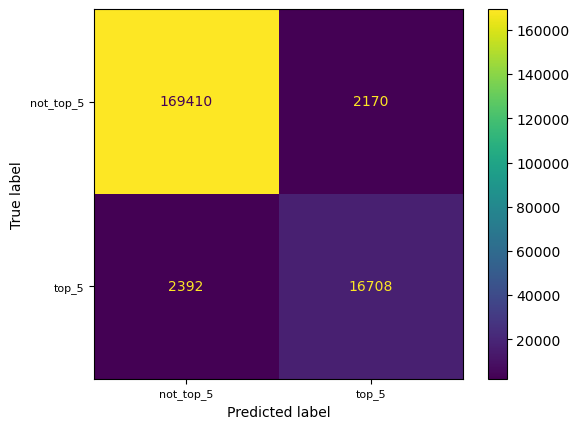

In [9]:
#lets review the quality using the standard metrics:
y_pred = y_pred_knn
print("Model KNN")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))

cm = metrics.confusion_matrix(y_test, y_pred, labels = knn.classes_)
_, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not_top_5', 'top_5'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
ax.set_yticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
display_cm.plot(ax = ax)

the results from this first model (KNN) are very promising with a balanced accuracy of 93%, a recall of 87.5% and F1 score of 0.88

Next lets try a different model that could be potentially better suited for this problem.

<h3>Logistic Regression</h3>

In [10]:
from sklearn.linear_model import LogisticRegression
#we will use the weights to make up for the imbalance of classes in this project
weights = {0:10, 1:90} 
clf = LogisticRegression(solver = 'newton-cholesky', max_iter = 500, class_weight = weights)
clf.fit(X_train, y_train) 
y_pred_lr = clf.predict(X_test)

Model Logistic Regression
Accuracy: 0.574
Balanced accuracy: 0.555
Precision score for "Yes":  0.123
Precision score for "No": 0.917
Recall score for "Yes": 0.531
Recall score for "No": 0.578
F1 score: 0.200


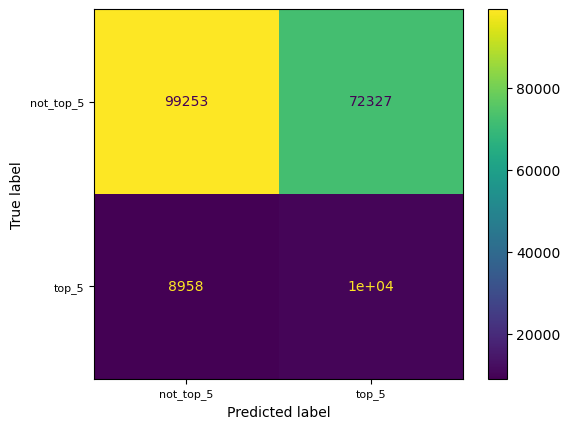

In [11]:
#lets review the quality using the standard metrics:
y_pred = y_pred_lr
print("Model Logistic Regression")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))


cm = metrics.confusion_matrix(y_test, y_pred, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not_top_5', 'top_5'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
ax.set_yticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
display_cm.plot(ax = ax)

As we can see, the logistic regression model gave us lower quality results than the KNN model (with a balanced accuracy of 55%, recall of 53.1% and F1 of 0.2) overall much lower than the KNN model.
Next, we will try a Random Forest:

<h3>Random Forest</h3>

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Model Random Forest
Accuracy: 0.978
Balanced accuracy: 0.936
Precision score for "Yes":  0.900
Precision score for "No": 0.987
Recall score for "Yes": 0.882
Recall score for "No": 0.989
F1 score: 0.891


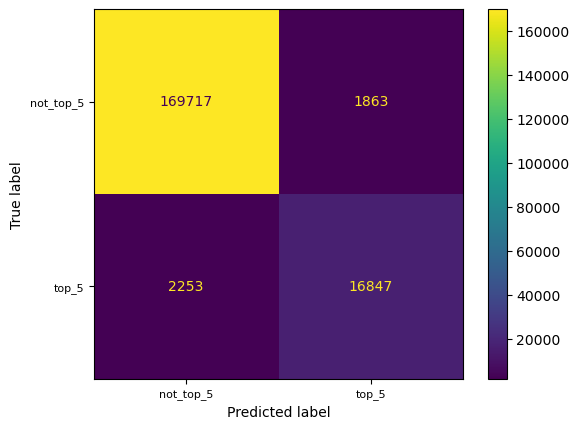

In [13]:
#lets review the quality using the standard metrics:
y_pred = y_pred_rf
print("Model Random Forest")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))


cm = metrics.confusion_matrix(y_test, y_pred, labels = rf.classes_)
_, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not_top_5', 'top_5'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
ax.set_yticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
display_cm.plot(ax = ax)

So far, it looks like this model is the best performing model. with a balanced accuracy of 93.6%, recall of 88.2% and F1 of .891, this is so far the best model.

Next, we will try another ensemble method, the Gradient Boosting:

<h3>Gradient Boosting</h3>

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

Gradient Boosting
Accuracy: 0.902
Balanced accuracy: 0.516
Precision score for "Yes":  0.726
Precision score for "No": 0.903
Recall score for "Yes": 0.034
Recall score for "No": 0.999
F1 score: 0.064


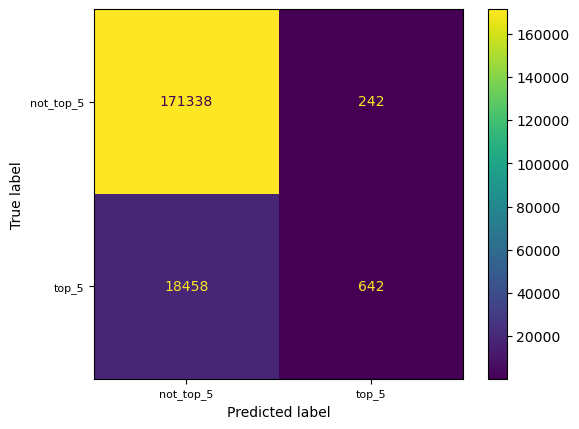

In [18]:
#lets review the quality using the standard metrics:
y_pred = y_pred_gb
print("Gradient Boosting")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))


cm = metrics.confusion_matrix(y_test, y_pred, labels = gb.classes_)
_, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not_top_5', 'top_5'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
ax.set_yticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
display_cm.plot(ax = ax)

This last model shows lower quality results with a balanced accuracy of 51.6%, recall of just 3.4% and F1 of 0.064. Based on the results seen, we want to try and optimize a random forest model to try and get the best results possible.

<h2>Optimizing 2 ways</h2>

Firs lets try to optimize the Random Forest Model using Gridsearch:

In [19]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth':np.arange(1,100, 10)}
ran_for = RandomForestClassifier()
ran_for_cv= GridSearchCV(ran_for,param_grid,cv=5)


In [20]:
ran_for_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])})

In [21]:
print("Best Score:" + str(ran_for_cv.best_score_))
print("Best Parameters: " + str(ran_for_cv.best_params_))

Best Score:0.9777600467499774
Best Parameters: {'max_depth': 61}


In [22]:
y_pred = ran_for_cv.predict(X_test)

Random Forest Best Grid Search
Accuracy: 0.978
Balanced accuracy: 0.940
Precision score for "Yes":  0.892
Precision score for "No": 0.988
Recall score for "Yes": 0.891
Recall score for "No": 0.988
F1 score: 0.892


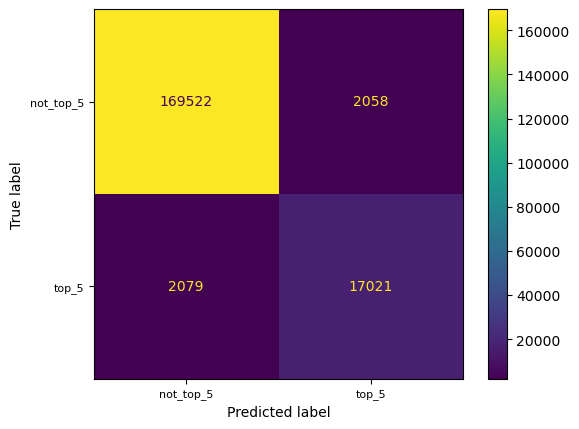

In [23]:
print("Random Forest Best Grid Search")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))


cm = metrics.confusion_matrix(y_test, y_pred, labels = gb.classes_)
_, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not_top_5', 'top_5'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
ax.set_yticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
display_cm.plot(ax = ax)

The results of the Gridsearch are promising with a balanced accuracy of 94%, recall of 89.1% and F1 score of .892. However, Lets use Bayesian optimization to try to improve around this model.

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
def rf_eval(max_depth, min_samples_split, min_samples_leaf, n_estimators):
    rf_mod = RandomForestClassifier(max_depth =  int(max_depth), min_samples_split = int(min_samples_split), min_samples_leaf = int(min_samples_leaf), n_estimators = int(n_estimators))
    scores = cross_val_score(rf_mod, X_train, y_train, scoring='f1', cv = 3)
    return scores.mean()

In [ ]:
from bayes_opt import BayesianOptimization

lgbBO = BayesianOptimization(rf_eval, {'max_depth': (50, 70),
                                                'min_samples_split': (2, 10),
                                                'min_samples_leaf': (1, 4),
                                                'n_estimators' : (50, 150)
                                                },allow_duplicate_points = True)

lgbBO.maximize(n_iter=5, init_points=2)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8832    | 65.94     | 1.562     | 2.14      | 129.4     |
| 2         | 0.8765    | 53.07     | 2.901     | 7.947     | 80.21     |
| 3         | 0.8816    | 66.39     | 2.217     | 2.179     | 128.3     |


In [ ]:
lgbBO.max

In [ ]:
rf_mod = RandomForestClassifier(max_depth =  31, min_samples_split = 2, min_samples_leaf = 1, n_estimators = 79)
rf_mod.fit(X_train, y_train)
y_pred = rf_mod.predict(X_test)

In [ ]:
print("Random Forest Best Bayesian Opt")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No": %.3F'%metrics.precision_score(y_test,y_pred, pos_label=0))
print('Recall score for "Yes": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No": %.3F'%metrics.recall_score(y_test,y_pred, pos_label = 0))
print('F1 score: %.3F'%metrics.f1_score(y_test,y_pred))


cm = metrics.confusion_matrix(y_test, y_pred, labels = gb.classes_)
_, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not_top_5', 'top_5'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
ax.set_yticklabels(labels = ['not_top_5', 'top_5'], fontsize = 8)
display_cm.plot(ax = ax)

The results from the Bayesian Optimization are just slightly worse with a balanced accuracy of 95%, recall of 90.5% and F1 of 0.93. Since the results are almost as good, we will use these results as our best model since the n_estimators is lower than the first model and as such it will require lower computational power.

In [ ]:
#save the best model as best_ran_for
best_ran_for = rf_mod

In [ ]:
#import the column names
x_cols = np.load('../data/train_test/xcolumns.npy', allow_pickle=True)

In [ ]:
#plot a graph of feature importance for this model
imps = best_ran_for.feature_importances_
rf_feat_imps = pd.DataFrame({'Col':x_cols, 'importance':best_ran_for.feature_importances_}).sort_values(by='importance', ascending=False)
rf_feat_imps.plot(kind='bar', x='Col', y='importance', figsize=(10,6))
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

It looks like the best features that define wether a song will be in the top 5 or not are the weekly movement, the days since the relase, popularity and daily movement. the musical features seem to be relevant but a lot less. surprisingly the socioeconomic factors for each country does not influence the model.
The next thing we will do is save this model for deployment.

<h3>Saving the model</h3>

In [ ]:
sklearn_version

In [ ]:
print(np.version.version)

In [ ]:
#save the model and model information
best_model = best_ran_for
best_model.version = '1.0'
best_model.pandas_version = '2.2.2'
best_model.numpy_version = '1.26.4'
best_model.sklearn_version = '1.2.2'
best_model.X_columns = [col for col in x_cols]
best_model.build_datetime = '2024-06-26'

In [ ]:
# save the model
# save the iris classification model as a pickle file
model_pkl_file = "../models/songs_top5_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(best_model, file)